In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import string
import nltk

%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk import FreqDist
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Import libraries for predction
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

# WordCloud
#from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kllmm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#run from sagemaker notebook instance
import boto3
from sagemaker import get_execution_role
role = get_execution_role()
bucket='machine-learning-uni'
data_key = 'week3/Assignment/spam.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv('data_location',encoding='latin-1', sep=',', engine='python')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
df.describe()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [12]:
df_clean = df.copy()
df_clean.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
df_clean.rename(columns={'v1':'label','v2':'text'}, inplace=True)
df_clean.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


### To improve the model performance we could use resampling
    USE_RESAMPLE = True enable "resample" to increase 'spam' cases

In [13]:
USE_RESAMPLE = True
if USE_RESAMPLE:
    features_train, features_test, labels_train,labels_test = \
    train_test_split(df_clean['text'], df_clean['label'], test_size=.1, random_state=42)

    # resample 'spam' category to improve accurracy
    resampling = pd.concat([features_train, labels_train], axis=1)
    resampling.describe()
    df_spam = resampling[resampling['label'] == 'spam']
    df_ham = resampling[resampling['label'] == 'ham']
    df_spam_resampled = resample(df_spam, replace=True, n_samples=int(len(df_ham)*.48), random_state=42)

    df_sample = pd.concat([df_ham, df_spam_resampled])
    df_ham.describe()
else:
    df_sample = df_clean.copy()

<AxesSubplot: title={'center': 'Sample data'}, xlabel='label', ylabel='Count'>

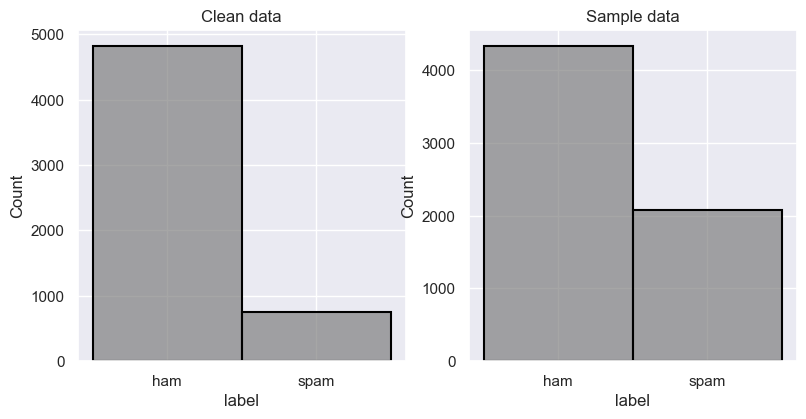

In [14]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
fig.tight_layout(h_pad=6)
axes[0].set_title('Clean data')
axes[1].set_title('Sample data')
sns.histplot(df_clean['label'], color='grey', bins=30, alpha=0.7, edgecolor='black', linewidth=1.5, ax=axes[0])
sns.histplot(df_sample['label'], color='grey', bins=30, alpha=0.7, edgecolor='black', linewidth=1.5, ax=axes[1])

In [15]:
df_sample['label'].value_counts()

ham     4334
spam    2080
Name: label, dtype: int64

In [16]:
# remove punctuation, stopwords and perform word stemming
def pre_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))  #remove punctuation
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]  #remove stopwords
    words = ""
    stemmer = SnowballStemmer("english")
    for i in text:  #word stemming
            
            words += (stemmer.stem(i))+" "
    return words

# import multiprocessing as mp

# def pre_process_worker(text):
#     text = text.translate(str.maketrans('', '', string.punctuation))
#     text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
#     words = ""
#     stemmer = SnowballStemmer("english")
#     for i in text:  #word stemming
#         #words = " ".join([stemmer.stem(i) for i in text])
#         words += (stemmer.stem(i))+" "
#     return words

# def pre_process(texts):
#     with mp.Pool(processes=mp.cpu_count()) as pool:
#         results = pool.map(pre_process_worker, texts)
#     return results


In [17]:
# Text transformation
# to lowercase and remove numbers
df_sample['text'] = df_sample['text'].str.lower()
df_sample['text'] = df_sample['text'].str.replace(r'\d+','')

# pre process text
textFeatures = df_sample['text'].copy()
textFeatures = textFeatures.apply(pre_process)

In [18]:
# Document-term-matrix creation
#create TfidVectorizer to create the numerical values
vectorizer = TfidfVectorizer(stop_words="english",decode_error='ignore', lowercase = True, min_df=2)

#numericalize the textFeatures
features = vectorizer.fit_transform(textFeatures.values.astype('U'))

#create the test and train datasets
features_train, features_test, labels_train,labels_test = \
train_test_split(features, df_sample['label'], test_size=0.33, random_state=42)

print('Train size: ', features_train.shape)
print('Test size: ', features_test.shape)

Train size:  (4297, 3428)
Test size:  (2117, 3428)


In [19]:
# Create model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

mnb = MultinomialNB(alpha=0.2)
mnb.fit(features_train, labels_train)
prediction = mnb.predict(features_test)
print('Accuracy of Model: ', accuracy_score(labels_test,prediction))

Accuracy of Model:  0.9829948039678791


In [20]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, preds):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, preds)

    # Create a dataframe with the confussion matrix values
    confusion_m = pd.DataFrame(cm, columns=['Predicted: ham', 'Predicted: spam'], \
        index=['Actual: ham', 'Actual: spam'])
    plt.figure(figsize = (10,10))
    # Plot the confusion matrix
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(confusion_m, annot=True,fmt='.0f', annot_kws={"size": 16}, cmap='Blues') # font size
    plt.show()

              precision    recall  f1-score   support

         ham     0.9923    0.9826    0.9874      1438
        spam     0.9639    0.9838    0.9738       679

    accuracy                         0.9830      2117
   macro avg     0.9781    0.9832    0.9806      2117
weighted avg     0.9832    0.9830    0.9830      2117



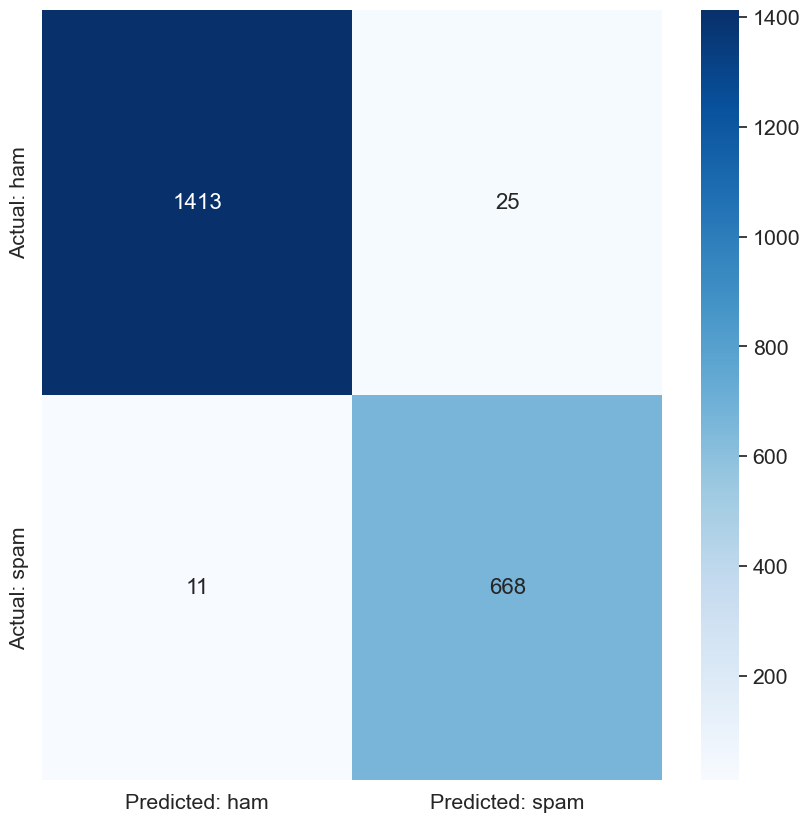

In [21]:
# Predicting the Test set results
preds = prediction

print(metrics.classification_report(labels_test, preds,  digits=4))
plot_confusion_matrix(labels_test, preds)

In [24]:
#get feature names from the vectorizer object created above and store it in a list 
feature_names = vectorizer.get_feature_names_out()
dense = features.todense()
denselist = dense.tolist()
df_vector = pd.DataFrame(denselist, columns=feature_names)

In [25]:
#df_vector.describe()

,aah,aathilov,ab,aberdeen,abi,abil,abiola,abj,abl,abt,...,zouk,zs,åð,åòit,ìll,ìï,ûªv,ûï,ûïharri,ûò
count,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,...,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000
mean,0.000233,0.000353,0.000307,0.000080,0.000324,0.000149,0.000567,0.000211,0.001405,0.001310,...,0.000162,0.000208,0.000234,0.000191,0.000156,0.002668,0.000296,0.000161,0.000160,0.000494
std,0.010956,0.016304,0.010031,0.004509,0.013784,0.008623,0.015882,0.012243,0.025333,0.024619,...,0.007501,0.008334,0.011576,0.007641,0.008817,0.034510,0.010598,0.007434,0.007392,0.016930
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.610082,0.754012,0.328103,0.255373,0.811136,0.575484,0.652044,0.823016,0.758621,0.763900,...,0.346897,0.333818,0.761968,0.306036,0.510271,0.753574,0.379691,0.343793,0.341869,0.872727


In [26]:
# visualize the data on a WordCloud
def visualize(label):
  
    words = ''
    for msg in df_sample[df_sample['label'] == label]['text'].apply(pre_process):
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width=600, height=600).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [27]:
df_sample['label'].unique()


array(['ham', 'spam'], dtype=object)

In [29]:
#visualize ('ham')

In [30]:

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=False)
    
    #get the feature names and tf-idf score of top n items
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [32]:
feature_names = vectorizer.get_feature_names_out()

sorted_items=sort_coo(features.tocoo())
sorted_items

keywords=extract_topn_from_vector(feature_names,sorted_items,5)
keywords

{'new': 0.048, 'good': 0.049, 'need': 0.053, 'free': 0.053}

In [51]:
#get the most frequent words in the dataset 
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#get the top 5 words in the dataset
top_words = get_top_n_words(df_sample['text'], 5)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
top_df

,Word,Freq
0,free,694
1,ur,621
2,just,511
3,txt,483
4,stop,399


In [52]:
#get the top 5 words in ham
top_words_ham = get_top_n_words(df_sample[df_sample['label']=='ham']['text'],5)
top_df_ham = pd.DataFrame(top_words_ham)
top_df_ham.columns=["Word", "Freq"]
top_df_ham

,Word,Freq
0,gt,293
1,lt,292
2,just,265
3,ok,264
4,ll,239


In [53]:
#get the top 5 words in spam
top_words_spam = get_top_n_words(df_sample[df_sample['label']=='spam']['text'],5)
top_df_spam = pd.DataFrame(top_words_spam)
top_df_spam.columns=["Word", "Freq"]
top_df_spam

,Word,Freq
0,free,640
1,txt,469
2,ur,397
3,stop,367
4,mobile,342


### Model without resampling (USE_RESAMPLE = False)

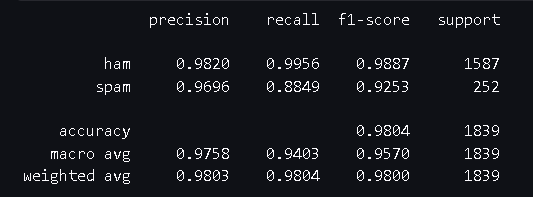, 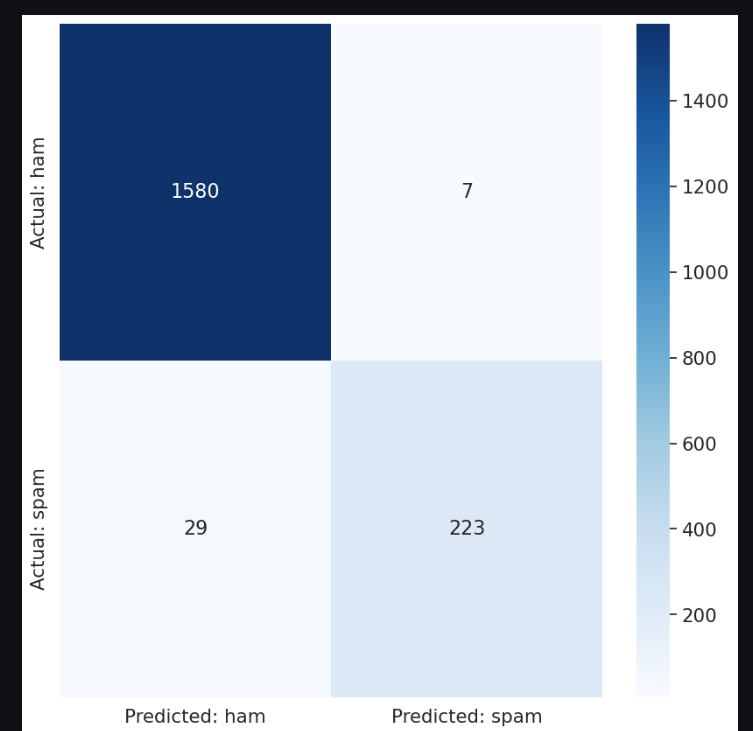

## Summary
- The model accuracy is excellent 98.04% before improvement 98.3%
- The model performance is very good, but the False-Negative values is high compared to False-Positives (incorrectly classified as Spam). <br>
In this context a lower FN could be preffered. This was improved in the final model by using Resampling, increasing the cases for the 'spam'  category.<br>
    The FP reduced from 29 to 11 cases.
- Yes, by the nature of the data the Spam cases is roughly 15%. As the resample shown the accuracy increased by having more 'spam' cases.

In [ ]:
import joblib
import tempfile
with tempfile.TemporaryFile() as tf:
    s3_client = boto3.client('s3')
    joblib.dump(mnb,tf)
    tf.seek(0)
    s3_client.put_object(Body=tf.read(), Bucket=bucket, Key='week3_solution.pkl')